In [1]:
import warnings
warnings.simplefilter("ignore")

import time
import logging
import numpy as np
import os 
import sys
import yaml
import pyomo.environ as pyomo_env
import pandas as pd
from scipy.spatial import ConvexHull,  Delaunay
from scipy.interpolate import griddata
from multiprocessing import Lock, Process, Queue, current_process
import queue # imported for using queue.Empty exception
sys.path.append(os.getcwd())
import plotly.graph_objects as go
import plotly.figure_factory as ff
warnings.simplefilter("ignore")
import pyomo
import matplotlib.pyplot as plt

### Load custom pypsa tools pacakge

In [2]:
import importlib.util
spec = importlib.util.spec_from_file_location("pypsa_tools.pypsaTools", "/home/tim/Dropbox/Speciale/PyPSA_project/pypsa_tools/pypsaTools.py")
pt = importlib.util.module_from_spec(spec)
spec.loader.exec_module(pt)
spec2 = importlib.util.spec_from_file_location("pypsa_tools.plottingTools", "/home/tim/Dropbox/Speciale/PyPSA_project/pypsa_tools/plottingTools.py")
pt_plot = importlib.util.module_from_spec(spec2)
spec2.loader.exec_module(pt_plot)


## Create network

In [3]:
network = pt.createNetwork(3)

Importing PyPSA from older version of PyPSA than current version 0.15.0.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network euro_00 has buses, carriers, generators, global_constraints, links, loads


## Initial solution

In [4]:
network, old_objective_value, initial_solution = pt.initialSolution(network)
initial_solution

name
DK onwind    22384.063037
DK ocgt        361.436619
NO onwind        0.000000
NO ocgt       1800.982048
SE onwind        0.000000
SE ocgt      14820.176985
Name: p_nom_opt, dtype: float64

## MGA with $\sum$ variables

In [5]:
options = dict(dim=3,old_objective_value=old_objective_value,convergence_percent=0.01)

data_detail_sum = pt.MGA(network,options,pt.gen_variables_3D,debug=False)

number of directions 4
1.0
number of directions 4
0.04711960809172385
number of directions 5
0.0


In [6]:
hull_sum = ConvexHull(data_detail_sum)
interior_points_sum = pt.create_interior_points(hull_sum,2000)

In [7]:
pt_plot.plot_scatter(hull_sum,initial_solution,data_detail_sum,interior_points_sum)

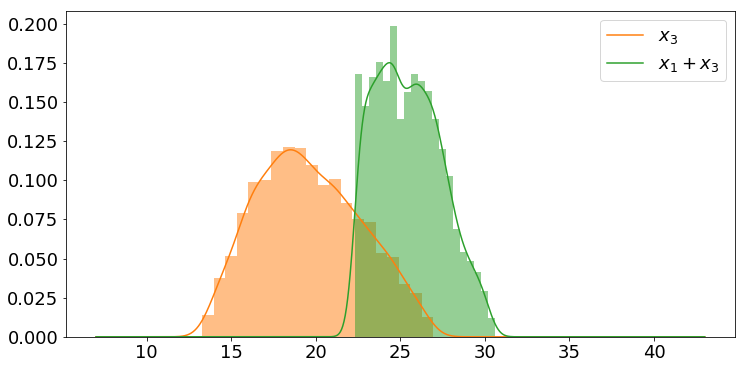

In [8]:
fig, ax = plt.subplots(figsize=(12,6))
ax = pt_plot.plot_hist(ax,interior_points_sum[:,0],color='C1')
ax = pt_plot.plot_hist(ax,interior_points_sum[:,1],color='C2')
ax.legend(['$x_3$','$x_1+x_3$'])


## Max/Min all variables

In [9]:
options = dict(dim=3,old_objective_value=old_objective_value,convergence_percent=np.inf)
data_detail_maxmin = pt.MGA(network,options,pt.gen_variables_fullD)


number of directions 12
1.0


# New Multiplicity function

In [10]:
#from sympy import *
#from sympy import Matrix

from pypsa_tools.arTools import *

spec = importlib.util.spec_from_file_location("pypsa_tools.pypsaTools", "/home/tim/Dropbox/Speciale/PyPSA_project/pypsa_tools/pypsaTools.py")
pt = importlib.util.module_from_spec(spec)
spec.loader.exec_module(pt)

ModuleNotFoundError: No module named 'pypsa_tools'

In [12]:
sample_points = pt.create_interior_points(hull_sum,500)
sample_points = np.concatenate([data_detail_sum,sample_points])

#sample_points = np.concatenate([data_detail_sum,interior_points_sum])

In [12]:
def calc_multiplicity(P):

    H_list = []
    i = 0
    for p in P:
        A,b = vert2con(data_detail_maxmin[:,0+i::2])
        AA = np.array([A[:,i]-A[:,-1] for i in range(A.shape[1]-1)]).T
        bb = b-A[:,-1]*P[i]

        try :
            V = con2vert(AA,bb)
            H = ConvexHull(V).volume
        except : 
            H = 1
        i = i+1
        H_list.append(H)
        
    return H_list[0]*H_list[1]

In [13]:
weights = [calc_multiplicity([P[1],P[0]]) for P in sample_points]

In [14]:
weights

[39281444.73222426,
 56042238.51413386,
 1756.647153899477,
 73582258.19896485,
 1756.6471538980659,
 56042238.51413386,
 256075014884040.78,
 73582258.1989649,
 1756.647153898236,
 256075014884040.88,
 73582258.1989649,
 39281444.73222426,
 56042238.51413386,
 31353286.202024996,
 28566019.501049455,
 99952214450274.78,
 90728986854009.62,
 422111489148762.5,
 24112254.49291875,
 179721250524949.28,
 622009573525455.4,
 813358065760570.0,
 31856696762016.57,
 112255242239.85379,
 30487960.46428139,
 33296738.81444724,
 931390345714352.4,
 214919189280947.8,
 20501855.547022156,
 451055933941504.56,
 1006379517561051.5,
 1642780356522766.5,
 918620066338729.2,
 145769073537321.38,
 562712999087250.0,
 1457031836646026.5,
 123532008248534.33,
 2114898527192894.5,
 39206192.16281679,
 1914362864361089.2,
 1682136495801617.2,
 388627512104407.3,
 753236224547537.2,
 2053105695249332.8,
 17899500027302.773,
 1019202975477466.0,
 435432283535197.9,
 2575726604147832.0,
 10107960498188.223,


In [15]:
interior_weights = griddata(sample_points[:len(weights)], 
                                    weights, 
                                    interior_points_sum,
                                    method='linear')


In [16]:
pt_plot.plot_scatter(hull_sum,initial_solution,data_detail_sum,sample_points,weights)

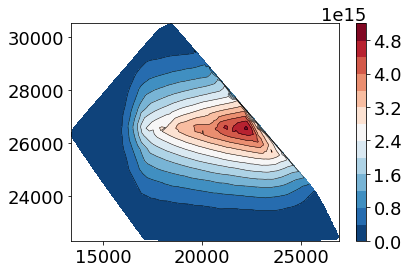

In [90]:
pt_plot.plot_contour(interior_points_sum[:,0],interior_points_sum[:,1],interior_weights)

In [30]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np

def plot_test(x,y,z):
    fig, (ax1) = plt.subplots(nrows=1)

    plot_range = ((min(x),max(x)),(min(y),max(y)))

    npts = 200
    ngridx = 1000
    ngridy = 1000
    # -----------------------
    # Interpolation on a grid
    # -----------------------
    # A contour plot of irregularly spaced data coordinates
    # via interpolation on a grid.

    # Create grid values first.
    xi = np.linspace(plot_range[0][0], plot_range[0][1], ngridx)
    yi = np.linspace(plot_range[1][0],plot_range[1][1], ngridy)

    # Perform linear interpolation of the data (x,y)
    # on a grid defined by (xi,yi)
    #triang = tri.Triangulation(x, y)
    #interpolator = tri.LinearTriInterpolator(triang, z)
    #Xi, Yi = np.meshgrid(xi, yi)
    #zi = interpolator(Xi, Yi)

    # Note that scipy.interpolate provides means to interpolate data on a grid
    # as well. The following would be an alternative to the four lines above:
    from scipy.interpolate import griddata
    zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='linear')


    ax1.contour(xi, yi, zi, levels=14, linewidths=0.5, colors='k')
    cntr1 = ax1.contourf(xi, yi, zi, levels=14, cmap="RdBu_r")

    fig.colorbar(cntr1, ax=ax1)
    #ax1.plot(x, y, 'ko', ms=3)
    ax1.set(xlim=(plot_range[0][0], plot_range[0][1]), 
            ylim=(plot_range[1][0], plot_range[1][1]))
    #ax1.set_title('grid and contour (%d points, %d grid points)' %
    #            (npts, ngridx * ngridy))



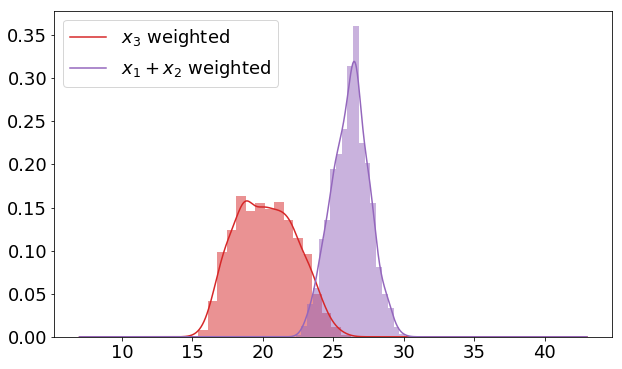

In [32]:
fig, ax = plt.subplots(figsize=(10,6))
#ax = plot_hist(ax,interior_points_sum[:,0],color='C1')
#ax = plot_hist(ax,interior_points_sum[:,1],color='C2')
ax = pt_plot.plot_hist(ax,interior_points_sum[:,0],color='C3',w=interior_weights)
ax = pt_plot.plot_hist(ax,interior_points_sum[:,1],color='C4',w=interior_weights)
ax.legend(['$x_3$ weighted','$x_1+x_2$ weighted'])
#fig.xlabel('MW installed capacity')

### True Solution

In [33]:
options = dict(old_objective_value=old_objective_value,convergence_percent=0.5)

data_detail_full = pt.MGA(network,options,pt.gen_variables_fullD)

number of directions 12
1.0
number of directions 59
0.46918375800810863


In [34]:
hull_full = ConvexHull(data_detail_full,qhull_options='Q12')
interior_points_full = pt.create_interior_points(hull_full,5000)

In [52]:
data1 = np.concatenate([[interior_points_full[:,1::2].sum(axis=1)],                                    [interior_points_full[:,0::2].sum(axis=1)]],axis=0).T

data2 = np.concatenate([[data_detail_full[:,1::2].sum(axis=1)],                                       [data_detail_full[:,0::2].sum(axis=1)]],axis=0).T

In [96]:
h,x_bins,y_bins = np.histogram2d(data1[:,0],data1[:,1],bins=10)
x,y = np.meshgrid(x_bins[0:-1]-(x_bins[0]-x_bins[1])/2,
                    y_bins[0:-1]-(y_bins[0]-y_bins[1])/2)
data3=np.concatenate([[x.flatten()],[y.flatten()],[h.T.flatten()]],axis=0).T
data3 = data3[data3[:,2]>0,:]
test = np.concatenate([data_detail_sum.T,[np.zeros(data_detail_sum.shape[0])]],axis=0).T
data3 = np.append(data3,test,axis=0)


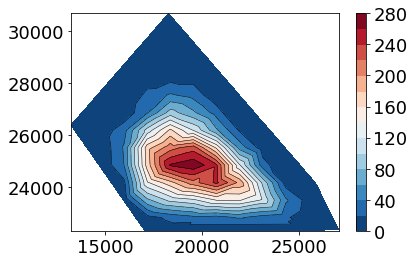

In [97]:
pt_plot.plot_contour(data3[:,0],data3[:,1],data3[:,2])

In [92]:
pt_plot.plot_scatter(hull_sum,initial_solution,data1,data2)

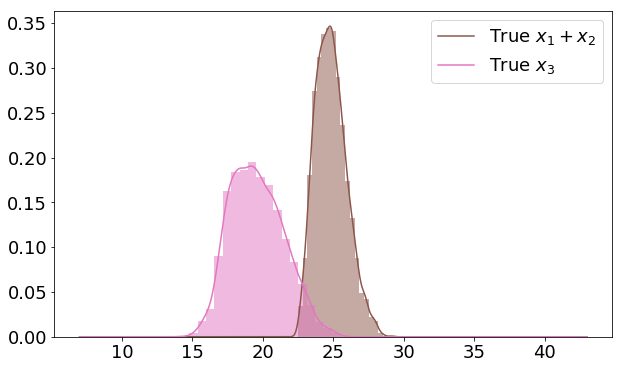

In [98]:
fig, ax = plt.subplots(figsize=(10,6))
ax = pt_plot.plot_hist(ax,interior_points_full[:,0::2].sum(axis=1),color='C5')
ax = pt_plot.plot_hist(ax,interior_points_full[:,1::2].sum(axis=1),color='C6')
ax.legend(['True $x_1+x_2$','True $x_3$'])

Text(0, 0.5, 'Probability density')

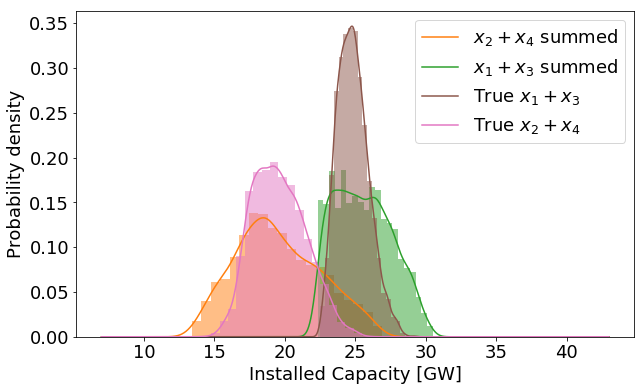

In [99]:
fig, ax = plt.subplots(figsize=(10,6))
ax = pt_plot.plot_hist(ax,interior_points_sum[:,0],color='C1')
ax = pt_plot.plot_hist(ax,interior_points_sum[:,1],color='C2')
ax = pt_plot.plot_hist(ax,interior_points_full[:,0::2].sum(axis=1),color='C5')
ax = pt_plot.plot_hist(ax,interior_points_full[:,1::2].sum(axis=1),color='C6')
ax.legend(['$x_2+x_4$ summed','$x_1+x_3$ summed','True $x_1+x_3$','True $x_2+x_4$'])
ax.set_xlabel('Installed Capacity [GW]')
ax.set_ylabel('Probability density')
#fig.savefig("C:/Users\Tim\OneDrive - Aarhus universitet\Speciale\Report\Images\multi_4D_1.pdf", bbox_inches='tight')

Text(0, 0.5, 'Probability density')

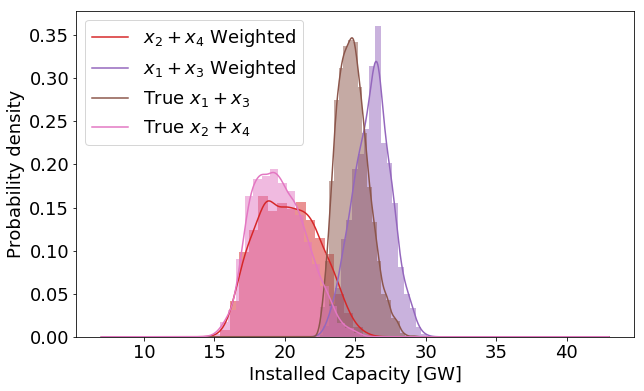

In [100]:
fig, ax = plt.subplots(figsize=(10,6))
#ax = plot_hist(ax,interior_points_sum[:,0],color='C1')
#ax = plot_hist(ax,interior_points_sum[:,1],color='C2')
ax = pt_plot.plot_hist(ax,interior_points_sum[:,0],color='C3',w=interior_weights)
ax = pt_plot.plot_hist(ax,interior_points_sum[:,1],color='C4',w=interior_weights)
ax = pt_plot.plot_hist(ax,interior_points_full[:,0::2].sum(axis=1),color='C5')
ax = pt_plot.plot_hist(ax,interior_points_full[:,1::2].sum(axis=1),color='C6')
ax.legend(['$x_2+x_4$ Weighted','$x_1+x_3$ Weighted','True $x_1+x_3$','True $x_2+x_4$'])
ax.set_xlabel('Installed Capacity [GW]')
ax.set_ylabel('Probability density')
#fig.savefig("C:/Users\Tim\OneDrive - Aarhus universitet\Speciale\Report\Images\multi_4D_2.pdf", bbox_inches='tight')